In [1]:
import numpy as np
import pandas as pd
from math import ceil
import pickle
import random
with open('datapath.txt','r') as f:
    datapath=f.readlines()[0].rstrip()

In [2]:
with open('Cliente_ID_Stats.pkl','r') as f:
    cuenta_Cliente=pickle.load(f)

In [3]:
cuenta_Cliente.sort_values(ascending=False,inplace=True)

I looked at the top client before, but that one may have been really abnormal as it is "remision".

In [4]:
pd.read_csv(datapath+'cliente_tabla.csv.zip',index_col='Cliente_ID').loc[cuenta_Cliente.index[:20]]

,NombreCliente
Cliente_ID,
653378,PUEBLA REMISION
653039,QUERETARO DE ARTEAGA REMISION
652850,JALISCO REMISION
652889,CHIHUAHUA REMISION
1093627,SUPERAMA RIO MAYO
653124,TAMAULIPAS REMISION
625491,SOMAKI DE MEXICO 8644
5903732,WAL MART SUPER CENTER DOMINGO DIEZ CUERNAVACA
652940,GUANAJUATO REMISION


Superama Rio Mayo seems to be the top client that is an actual retailer. I can find it in google search.


In [5]:
myclient=1093627

In [6]:
cuenta_Cliente[myclient]

1394

In [7]:
traindtypes=pd.read_csv(datapath+'train.csv',nrows=10,parse_dates=False).dtypes.to_dict()
traindtypes['Semana']=np.uint8

In [8]:
traincols=pd.read_csv(datapath+'train.csv',nrows=10,parse_dates=False).columns

In [9]:
traincols

Index([u'Semana', u'Agencia_ID', u'Canal_ID', u'Ruta_SAK', u'Cliente_ID',
       u'Producto_ID', u'Venta_uni_hoy', u'Venta_hoy', u'Dev_uni_proxima',
       u'Dev_proxima', u'Demanda_uni_equil'],
      dtype='object')

In [10]:
test_features='Semana Agencia_ID Canal_ID Ruta_SAK Cliente_ID Producto_ID Demanda_uni_equil'.split()

In [11]:
#useful_features='Agencia_ID Producto_ID Ruta_SAK Semana'.split()
#useful_columns='Agencia_ID Producto_ID Ruta_SAK Semana Demanda_uni_equil'.split()

In [17]:
train=pd.DataFrame(columns=test_features)

In [13]:
chunksz=400000

In [18]:
trainit=pd.read_csv(datapath+'train.csv',parse_dates=False,dtype=traindtypes,chunksize=chunksz,iterator=True,usecols=test_features)

In [19]:
%%time
i=0
for chunk in trainit:
    if i%50==0:
        print(i)
    train=train.append(chunk[chunk['Cliente_ID']==myclient],ignore_index=True)
    i+=1
    

0
50
100
150
CPU times: user 50.4 s, sys: 4.04 s, total: 54.5 s
Wall time: 57.5 s


In [20]:
train.describe()

,Agencia_ID,Canal_ID,Cliente_ID,Demanda_uni_equil,Producto_ID,Ruta_SAK,Semana
count,1394.000000,1394.0,1394.0,1394.000000,1394.000000,1394.000000,1394.000000
mean,2485.717360,2.0,1093627.0,73.395983,33719.594692,5706.115495,5.940459
std,260.544026,0.0,0.0,68.342910,5448.763432,2822.464606,1.969265
min,2085.000000,2.0,1093627.0,1.000000,1182.000000,1519.000000,3.000000
25%,2085.000000,2.0,1093627.0,24.000000,31197.000000,1519.000000,4.000000
50%,2655.000000,2.0,1093627.0,53.500000,31200.000000,7705.000000,6.000000
75%,2655.000000,2.0,1093627.0,96.000000,34785.000000,7721.000000,8.000000
max,2655.000000,2.0,1093627.0,482.000000,49988.000000,7734.000000,9.000000


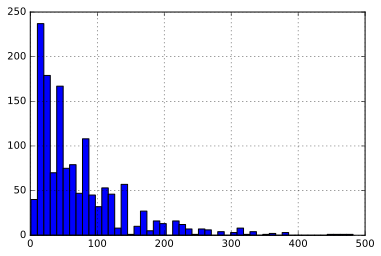

In [21]:
train['Demanda_uni_equil'].hist(bins=50)


This is a terrible distribution to do regression on. It looks close to exponential, and includes values at zero. Informed by our scoring metric, I'm going to take a look at $\log(demand + 1)$

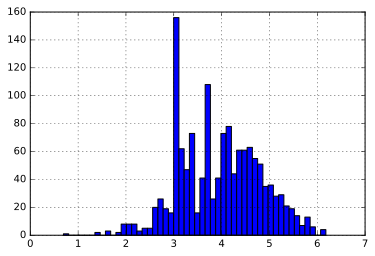

In [22]:
np.log(train['Demanda_uni_equil']+1.0).hist(bins=50)

In [20]:
{i:train[i].unique().shape[0] for i in train.columns}

{'Agencia_ID': 2,
 'Canal_ID': 1,
 'Cliente_ID': 1,
 'Demanda_uni_equil': 152,
 'Producto_ID': 91,
 'Ruta_SAK': 57,
 'Semana': 7}

These statistics are dramatically different from those we saw in `PUEBLA REMISION`. There are only two `Agencia_ID`s given, while there were many for `PUEBLA REMISION`.

In [25]:
train.groupby('Producto_ID').apply(lambda x: x['Agencia_ID'].unique().shape[0]).describe()

count    91.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
dtype: float64

Each `Producto_ID` seems to be delivered to this Superama from a single Agencia. It seems like there are probably 2 Agencias nearby, and they are differentiated by the products they supply.

It seems that one Agencia supplies a large number of products, with each delivered infrequently, while the other supplies a small number of products that are each delivered many times in the data set.

In [33]:
train.groupby('Agencia_ID').apply(lambda x: x['Producto_ID'].unique().shape[0])

Agencia_ID
2085.0    80
2655.0    11
dtype: int64

In [35]:
train.groupby(['Agencia_ID','Producto_ID']).size()[2085].describe()

count    80.000000
mean      5.175000
std       2.320928
min       1.000000
25%       3.750000
50%       7.000000
75%       7.000000
max       7.000000
dtype: float64

In [36]:
train.groupby(['Agencia_ID','Producto_ID']).size()[2655].describe()

count     11.000000
mean      89.090909
std       89.257442
min       10.000000
25%       18.000000
50%       47.000000
75%      148.000000
max      233.000000
dtype: float64

In [39]:
train.groupby('Producto_ID').apply(lambda x: x['Ruta_SAK'].unique().shape[0]).describe()

count    91.000000
mean      3.527473
std       7.944727
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      38.000000
dtype: float64

It also looks like the product largely determines the route. Over 75% of products are only delivered by a certain route, though there are some products that are delivered by a large number.